# 분류기(Classifier) 학습

## 데이터 종류에 따른 라이브러리 사용

이미지나 텍스트, 오디오, 비디오 데이터를 다룰 때는 표준 `Python` 패키지를 이용하여 `Numpy` 배열로 불러오면 됩니다.
이후, 배열을 `torch.*Tensor` 로 변환합니다.

* 이미지
    * Pillow, OpenCV, OpenGL 등
* 오디오
    * Scipy, LibROSA 등
* 텍스트
    * Python Lib, Cython, NLTK, SpaCy 등



Pytorch에는 위에 말한 데이터들을 처리하기 위해 `torchvision`, `torchtext`, `torchaudio` 등을 제공합니다.

해당 문서에서 사용할 패키지는 `torchvision`으로 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader) `torchvision.datasets` 과 이미지용 데이터 변환기(data.transformer) `torch.utils.data.DataLoader`가 포함되어 있습니다. 이를 보일러 플레이트 코드(bolierplate code)로 사용할 수 있습니다.

해당 문서에서는 Cifar10 데이터셋을 사용합니다.

![](https://tutorials.pytorch.kr/_images/cifar10.png)

# 이미지 분류기 학습

다음과 같은 단계로 진행합니다.

1. `torchvision`을 사용하여 CIFAR10의 학습용/시험용 데이터셋을 불러오고, 정규화(Normalizing) 합니다.
2. 합성곱 신경망(Convolution)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용

# 학습/테스트 데이터셋 불러오기

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset =  torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'car', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

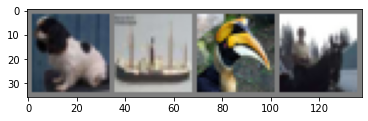

  dog  ship  bird horse


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 합성곱 신경망(Convolution Neural Network)) 정의

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()

# 손실 함수 및 Optimizer 정의

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 신경망 학습

단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면 됩니다.

In [10]:
for epoch in range(2):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if(i%2000 == 1999): 
            print('[{0}, {1}] loss: {2}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0


[1, 2000] loss: 2.216474040687084
[1, 4000] loss: 1.8311903056800365
[1, 6000] loss: 1.6847298959195613
[1, 8000] loss: 1.5761112231910228
[1, 10000] loss: 1.5054532557427882
[1, 12000] loss: 1.4828893900215625
[2, 2000] loss: 1.412364018253982
[2, 4000] loss: 1.4003077207431198
[2, 6000] loss: 1.3560244849994778
[2, 8000] loss: 1.3378462195992469
[2, 10000] loss: 1.3220291888788342
[2, 12000] loss: 1.3174894663095473


# 신경망 저장

학습한 모델을 저장합니다

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 시험용 데이터로 신경망 검사하기

학습용 데이터셋을 2회 반복하며 신경망을 학습하였습니다. 학습 후 신경망이 제대로 학습되었는 지 시험을 진행합니다.

신경망이 예측한 출력과 진짜 정답(Ground-Truth)을 비교하는 방식으로 확인합니다. 만약 예측이 맞다면 샘플은 맞은 예측값(correct predictions) 목록에 넣습니다.

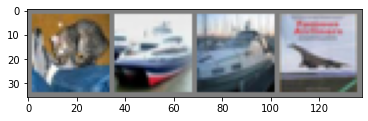

GroundTruth:    car  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 신경망 모델 불러오기

In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# 신경망 예측

In [16]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    car   car   car plane


In [21]:
correct, total = 0, 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print("Accuracy: {0}".format(100*correct/total))

Accuracy: 53.9


In [26]:
class_correct, class_total = list(0. for i in range(10)), list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print("Accuracy: {0}: {1}".format(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy: plane: 59.3
Accuracy: car: 76.1
Accuracy: bird: 32.9
Accuracy: car: 28.7
Accuracy: deer: 49.5
Accuracy: dog: 69.8
Accuracy: frog: 69.1
Accuracy: horse: 48.6
Accuracy: ship: 50.6
Accuracy: truck: 54.4


# GPU에서 학습하기

Tensor를 GPU에서 이동했던 것처럼, 신경망 또한 GPU로 욺길 수 있습니다.
CUDA 장치를 사용할 수 있도록 설정을 진행합니다.

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


해당 메소드(Method)들은 재귀적으로 모든 모듈의 매개변수와 버퍼를 CUDA Tensor로 변경합니다.

In [28]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

각 단계에서 입력(input)과 정답(target)도 GPU로 보내야 한다는 것도 기억해야 합니다.

In [30]:
inputs, labels = data[0].to(device), data[1].to(device)